In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import tensorflow as tf
import h5py, os, yaml
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from tqdm import tqdm
import glob
import pandas as pd
import subprocess
import itertools
import tfr_evaluate, util
import explain
import embed
import metrics
import quant_GIA
from test_to_bw_fast import read_model, get_config


In [2]:
testset, targets = tfr_evaluate.collect_whole_testset(coords=True)
C, X, Y = util.convert_tfr_to_np(testset, 3)

In [3]:
run_path = '../paper_runs/new_models/32_res/run-20211023_095131-w6okxt01/files/best_model.h5'
model = tf.keras.models.load_model(run_path)

In [4]:
X_set = quant_GIA.select_set('all_threshold', C, X, Y)

In [37]:
gi = quant_GIA.GlobalImportance(model, targets)

In [38]:
gi.set_null_model('dinuc', base_sequence=X_set, num_sample=1000)



In [39]:
motif_to_test = [('TGA', 1000), ('TCA', 1000+len('TGA')+1)]
diff1 = gi.embed_predict_quant_effect(motif_to_test).mean(axis=1)

In [40]:
p1 = 1000
p2 = 1200

motif_to_test = [('TGA', p1), ('TCA', p1+len('TGA')+1),
                ('TGA', p2),('TCA', p2+len('TGA')+1)]
diff2 = gi.embed_predict_quant_effect(motif_to_test).mean(axis=1)

In [41]:
p1 = 1000
p2 = 1200
p3 = 1400

motif_to_test = [('TGA', p1), ('TCA', p1+len('TGA')+1),
                ('TGA', p2),('TCA', p2+len('TGA')+1),
                ('TGA', p3),('TCA', p3+len('TGA')+1)]
diff3 = gi.embed_predict_quant_effect(motif_to_test).mean(axis=1)

In [48]:
gi.embedded_predictions.keys()
'TGA TGAat 1000 & TCA at 1004'.count('TGA')

2

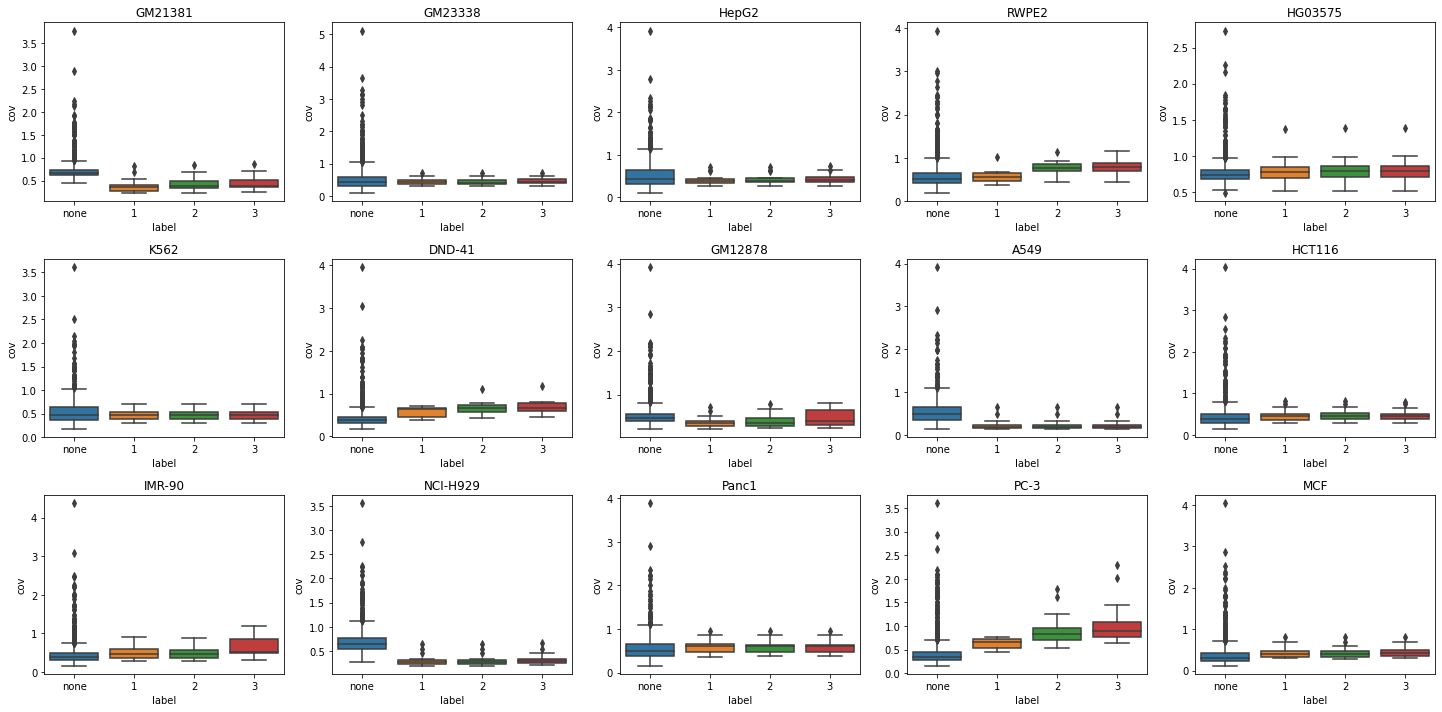

In [59]:
fig = plt.figure(figsize=[20,10]) 
for cell_line in range(15):
    dfs = [pd.DataFrame()]
    dfs[0]['cov'] = gi.null_profiles.mean(axis=1)[:,cell_line]
    dfs[0]['label'] = 'none'
    ax = fig.add_subplot(3, 5, cell_line+1)
    for k in gi.embedded_predictions.keys():
        df = pd.DataFrame()
        df['cov'] = gi.embedded_predictions[k].mean(axis=1)[cell_line]
        df['label'] = str(k.count('TGA'))
        dfs.append(df)
    dfs = pd.concat(dfs)
    sns.boxplot(data=dfs, x='label', y='cov', ax=ax)
    ax.set_title(targets[cell_line])

plt.tight_layout()



<AxesSubplot:xlabel='label', ylabel='cov'>

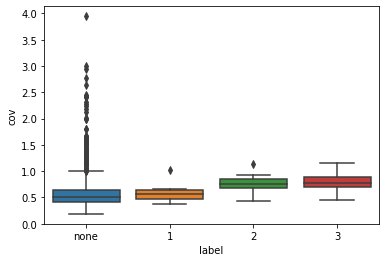

In [2]:
all_flank_results = pd.read_csv('add_GIA/logitsrun-20210825_040148-nieq47kf/PC-3_..TGA.TCA../dinuc/flanks.csv')

In [3]:
cell_line_name = 'PC-3'

In [4]:
best_pc3_flank = all_flank_results[all_flank_results['cell line'] == cell_line_name].sort_values('mean difference').iloc[-1,0]

In [5]:
best_pc3_flank

'GATGACTCATC'

In [6]:
positional_bias_results = pd.read_csv('add_GIA/logitsrun-20210825_040148-nieq47kf/PC-3_..TGA.TCA../dinuc/positional_bias_analysis.csv')

<AxesSubplot:xlabel='position', ylabel='mean difference'>

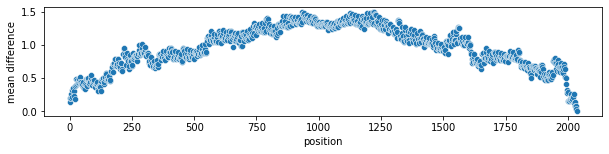

In [7]:
plt.figure(figsize=[10,2])
df = positional_bias_results[positional_bias_results['cell line'] == 'PC-3']
sns.scatterplot(data=df, x='position',
    y='mean difference')

In [ ]:
fig, axs = plt.subplots(1,1, figsize=[10,4], sharey=True)
#for m, motif1_pos in enumerate([1024]):
motif1_pos = 1024
distance_df = pd.read_csv('add_GIA/run-20210825_040148-nieq47kf/PC-3_..TGA.TCA.._and_..TGA.TCA../{}_distance.csv'.format(motif1_pos))
distance_df['motif 2 position'] = [int(d.split('_')[1]) for d in distance_df['motif 2'].values]

larger_than = motif1_pos+len('..TGA.TCA..')
smaller_than = motif1_pos-len('..ATAAA..')

distance_df =distance_df[(distance_df['motif 2 position']>larger_than)|(distance_df['motif 2 position']<smaller_than)]
df = distance_df[(distance_df['cell line']=='Panc1')|(distance_df['cell line']=='PC-3')]
sns.lineplot(data=df, x='motif 2 position',
               y = 'mean difference', hue='cell line', ax=axs)
axs.set_xlim(motif1_pos-300, motif1_pos+300)
scale = df['mean difference'].values
axs.vlines(motif1_pos, scale.min(), scale.max(), color='r', linestyle='--', label='embedded position motif 1')
#axs.get_legend().remove()
axs.set_ylabel('Global importance')
axs.set_xlabel('ATAAA position')
plt.xlabel('Embedded position of motif 2')
axs.set_title('TGA.TCA at '+str(motif1_pos))
axs.legend(loc='upper left', bbox_to_anchor=[1,1])
plt.tight_layout()

In [383]:
best_dist_interaction[best_dist_interaction['motif']=='GATGACTCATA at 1024']['mean difference'].values

array([], dtype=float64)

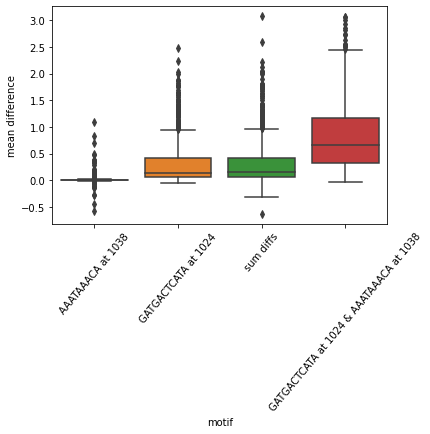

In [427]:
int_df = pd.read_csv('add_GIA_csvs/PC-3_..TGA.TCA.._and_..ATAAA../1024_best_distance_interaction.csv')
both_label = [s for s in set(int_df['motif'].values) if '&' in s][0]
motif1_label, motif2_label = both_label.split(' & ')

sum_values = int_df[int_df['motif']==motif1_label]['mean difference'].values+int_df[int_df['motif']==motif2_label]['mean difference'].values
df = pd.DataFrame({'mean difference':sum_values})
df['motif']='sum diffs'
df['cell line'] = int_df[int_df['motif']==motif1_label]['cell line']

best_dist_interaction = pd.concat([int_df, df], axis=0)
best_dist_interaction['motif'] = [b for b in best_dist_interaction['motif'].values]
sns.boxplot(data=best_dist_interaction[best_dist_interaction['cell line']== cell_line_name],
           x='motif', y='mean difference', order=[motif2_label,
                                                  motif1_label,
                                                  'sum diffs',
                                                 both_label])
plt.xticks(rotation=50);



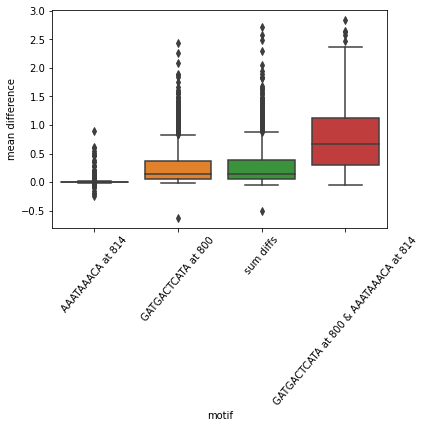

In [438]:
c = 'PC-3'
int_df = pd.read_csv('add_GIA_csvs/{}_..TGA.TCA.._and_..ATAAA../800_best_distance_interaction.csv'.format(c))
both_label = [s for s in set(int_df['motif'].values) if '&' in s][0]
motif1_label, motif2_label = both_label.split(' & ')

sum_values = int_df[int_df['motif']==motif1_label]['mean difference'].values+int_df[int_df['motif']==motif2_label]['mean difference'].values
df = pd.DataFrame({'mean difference':sum_values})
df['motif']='sum diffs'
df['cell line'] = int_df[int_df['motif']==motif1_label]['cell line']

best_dist_interaction = pd.concat([int_df, df], axis=0)
best_dist_interaction['motif'] = [b for b in best_dist_interaction['motif'].values]
sns.boxplot(data=best_dist_interaction[best_dist_interaction['cell line']==c],
           x='motif', y='mean difference', order=[motif2_label,
                                                  motif1_label,
                                                  'sum diffs',
                                                 both_label])
plt.xticks(rotation=50);


In [58]:
run_path = '../'+'paper_runs/new_models/32_res/run-20211023_095131-w6okxt01'
model, bin_size = read_model(run_path, compile_model=False)



In [59]:
testset, targets = tfr_evaluate.collect_whole_testset(coords=True)

cell_line = 13
low_C, low_X, low_Y = embed.threshold_cell_line_testset(testset, cell_line, more_than=1, less_than=2)
# [('none', low_X), ('dinuc', high_X), ('random', high_X)]

In [145]:
C, X, Y = util.convert_tfr_to_np(testset, 3)

In [146]:
high_X = quant_GIA.select_set('all_threshold', C, X, Y)

In [66]:
motif = '..TGA.TCA..'
util.make_dir('add_GIA_csvs')
base_dir = util.make_dir(os.path.join('add_GIA_csvs', '{}_{}_{}'.format(cell_line, 
                                                             targets[cell_line], 
                                                             motif)))
background_model = 'dinuc'
output_dir = util.make_dir(os.path.join(base_dir, background_model))

In [123]:
# for each background: low none, dinuc or random high for all cell lines
background_type, X_set = (background_model, low_X)
gi = quant_GIA.GlobalImportance(model, targets)
gi.set_null_model(background_type, base_sequence=X_set, num_sample=30)

In [124]:
all_motifs = generate_flanks(motif)

100%|██████████| 1024/1024 [00:00<00:00, 176196.56it/s]


In [179]:
all_scores = test_flanks(gi, all_motifs[:10], targets, 
                         output_path=os.path.join(output_dir, 'flanks.csv'))


100%|██████████| 10/10 [00:01<00:00,  9.76it/s]


In [182]:
gi.embed_predict_quant_effect([('TG', 2)]).shape

(30, 64, 15)

In [126]:
best_flank = all_scores[all_scores['cell line'] == 'PC-3'].sort_values('mean difference').iloc[-1,0]


In [147]:
df = gi.positional_bias(best_flank, range(0,2048//2,200), targets)

In [158]:
df[df['cell line']=='HepG2']

,position,mean difference,cell line,motif
2,0,0.005714,HepG2,AATGAATCACC
17,200,0.001377,HepG2,AATGAATCACC
32,400,0.003713,HepG2,AATGAATCACC
47,600,0.002765,HepG2,AATGAATCACC
62,800,0.012211,HepG2,AATGAATCACC
77,1000,0.017954,HepG2,AATGAATCACC


In [165]:
df[df['cell line']=='HepG2'].sort_values('mean difference').iloc[-1,0]

1000

In [133]:
mean_per_pos = score_per_position.mean(axis=1).mean(axis=1)
df = pd.DataFrame({'position':np.repeat(list(range(0,2048//2,200)), len(targets)), 
              'mean difference':np.array(mean_per_pos).flatten(), 
             'cell line': np.tile(targets, mean_per_pos.shape[0])})

In [135]:
df[df['cell line']=='HepG2']

,position,mean difference,cell line
2,0,0.005714,HepG2
17,200,0.001377,HepG2
32,400,0.003713,HepG2
47,600,0.002765,HepG2
62,800,0.012211,HepG2
77,1000,0.017954,HepG2


In [136]:
mean_per_pos[:,2]

array([0.00571414, 0.0013774 , 0.00371266, 0.00276477, 0.01221119,
       0.01795351], dtype=float32)

In [164]:
# load and get model layer
run_path = '../'+'paper_runs/new_models/32_res/run-20211023_095131-w6okxt01'
layer = -3
model, bin_size = read_model(run_path, compile_model=False)
aux_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
    

In [165]:
# load and threshold data
testset, targets = tfr_evaluate.collect_whole_testset(coords=True)


In [9]:
cell_line = 13
threshold = 2
thresholded_C, thresholded_X, thresholded_Y = embed.threshold_cell_line_testset(testset, cell_line)
predictions = embed.predict_np(thresholded_X, model, batch_size=32, reshape_to_2D=False)
thresholded_Y.shape

In [167]:
low_C, low_X, low_Y = embed.threshold_cell_line_testset(testset, cell_line, more_than=1, less_than=2)
low_pred = embed.predict_np(low_X, model, batch_size=32, reshape_to_2D=False)
low_Y.shape

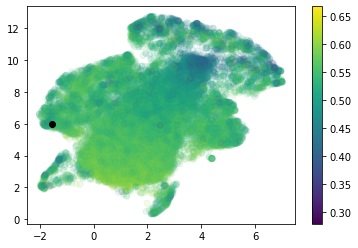

In [20]:
GC_content_all = get_GC_content(thresholded_X)
embeddings['GC content'] = GC_content_all

plt.scatter(x=embeddings['UMAP 1'], 
                y=embeddings['UMAP 2'],
                alpha=0.1,
                c=embeddings['GC content'],
               cmap='viridis_r')
plt.scatter(x=embeddings['UMAP 1'][2177], 
                y=embeddings['UMAP 2'][2177],c='k')

plt.clim(np.percentile(GC_content_all, 1),np.percentile(GC_content_all, 99))
c = plt.colorbar()
# plt.legend(bbox_to_anchor=(1,1));

In [250]:
# N, L, C = thresholded_Y.shape
# binned_Y = thresholded_Y.reshape(N, L//bin_size, bin_size, C).mean(axis=-2)
# mse = metrics.get_mse(binned_Y, 
#                       predictions).mean(axis=1).mean(axis=-1)
# pr = metrics.get_correlation_per_seq(binned_Y, 
#                       predictions, take_avg=False)        
# pr=np.array(pr).mean(axis=0)
# best_seqs = np.argwhere((mse<7) & (pr>0.89)).flatten()

# select sequences based on seamonster regions
# N = 1000
# top_N = np.argpartition(thresholded_Y.max(axis=1), -N)[-N:]
# left_N = np.argwhere(embed.select(embeddings, upper_lim_1=-1, lower_lim_2=5, idr='y')).flatten()
# left_idr_indx = left_N[np.argwhere((mse[left_N]<6) & (pr[left_N]>0.95)).flatten()]

In [271]:
motif_pattern = 'TGA.TCA'
alphabet='ACGT'
gi = GlobalImportance(model, alphabet)
gi.set_null_model('none', base_sequence=low_X, quant=True, num_sample=1000)  

In [76]:
# plt.plot(np.repeat((gi.embedded_predictions[:,:,1]).mean(axis=0), bin_size))
# plt.plot(np.repeat((gi.null_profiles[:,:,1]).mean(axis=0), bin_size))

In [191]:
%%time
kmer_size = 5
kmers = ["".join(p) for p in itertools.product(list(alphabet), repeat=kmer_size)]
all_motifs = []
all_scores = []

for kmer in tqdm(kmers):
    all_scores_per_motif = []
    motif_with_flanking_nucls = kmer[:2]+motif_pattern[:3]+kmer[2]+motif_pattern[4:]+kmer[3:]
    all_motifs.append(motif_with_flanking_nucls)
    diff_scores = gi.embed_predict_quant_effect([(motif_with_flanking_nucls, 1024)])
    all_scores_per_motif=(diff_scores).mean(axis=0).mean(axis=0)
    all_scores.append(all_scores_per_motif)

100%|██████████| 1024/1024 [45:32<00:00,  2.67s/it]

CPU times: user 19min 32s, sys: 2min 23s, total: 21min 56s
Wall time: 45min 32s


Text(0.5, 1.0, '# overlapping top 100 flanking motifs')

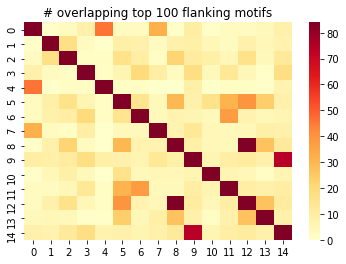

In [251]:
np_scores = np.array(all_scores)
top_N = 100
all_matches = []
for sort_by in range(15):
    l = []
    for c in range(15):
        l.append((np.sort([np_scores[:,c].argsort()[::-1][:top_N]]) == np.sort([np_scores[:,sort_by].argsort()[::-1][:top_N]])).sum())
    all_matches.append(l)

range_of_vals = np.sort(np.unique(np.array(all_matches).flatten()))
sns.heatmap(all_matches, vmin=range_of_vals[0], vmax = range_of_vals[-2], cmap='YlOrRd')
plt.title('# overlapping top 100 flanking motifs')

In [210]:
best_motif_and_flanking_nucls = all_motifs[np.argmax(np_scores[:,13])]
best_motif_and_flanking_nucls

'GATGACTCATA'

([<matplotlib.axis.XTick at 0x7f52882bcbe0>], [Text(0, 0, 'GATGACTCATA')])

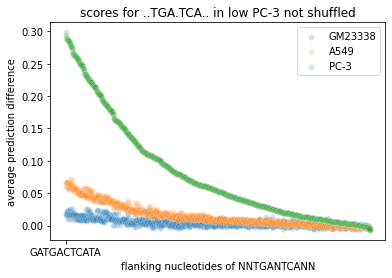

In [252]:
for c in [1,8,13]:
    sns.scatterplot(x=range(len(pc3_scores)), 
                    y=np_scores[:,c][pc3_scores.argsort()[::-1]], 
                    label=targets[c],
                    alpha=0.2
                   )
plt.xlabel('flanking nucleotides of NNTGANTCANN')
plt.ylabel('average prediction difference')
plt.title('scores for ..TGA.TCA.. in low PC-3 not shuffled')
plt.xticks([0], [best_motif_and_flanking_nucls])


In [123]:
%%time
all_positions = []
all_position_scores = []

for position in tqdm(range(0,2048-len(best_motif_and_flanking_nucls),2)):
    all_positions.append(position)
    diff_scores = gi.embed_predict_quant_effect([(best_motif_and_flanking_nucls, position)])
    all_position_scores.append(((diff_scores).mean(axis=0)).mean(axis=0))

100%|██████████| 1019/1019 [46:08<00:00,  2.72s/it]

CPU times: user 18min 35s, sys: 4min 16s, total: 22min 52s
Wall time: 46min 8s


In [156]:
dfs = []
for i in range(15):
    df = pd.DataFrame({'position':all_positions, 
                    'delta prediction':np.array(all_position_scores)[:,i]})
    df['cell line'] = targets[i]
    dfs.append(df)

all_deltas = pd.concat(dfs)
center_only = all_deltas[(all_deltas['position']>200)&(all_deltas['position']<1900)]

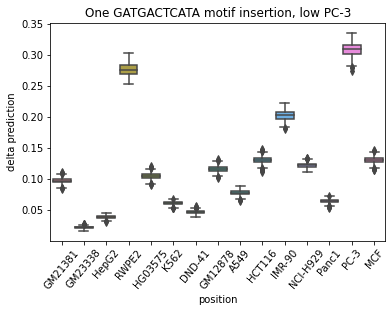

In [264]:
# for i in range(15):
best_motif_and_flanking_nucls = all_motifs[np.argmax(np_scores[:,13])]
sns.boxplot(data=center_only, x='cell line', y='delta prediction')
plt.title('One {} motif insertion, low PC-3'.format(best_motif_and_flanking_nucls))
plt.xlabel('position')
plt.ylabel('delta prediction')
# plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=50);

# position and multiplicity

In [116]:
all_position_scores_two = []
for position in tqdm(range(0,2048-len(best_motif_and_flanking_nucls),2)):
        diff_scores = gi.embed_predict_quant_effect([(best_motif_and_flanking_nucls, 1024),
                                                     (best_motif_and_flanking_nucls, 
                                                      position)])
        all_position_scores_two.append((diff_scores[:,:,cell_line]).mean())


100%|██████████| 1019/1019 [45:59<00:00,  2.71s/it]


Text(0.5, 1.0, '2 instances of GATGACTCATA \n data=thresholded PC-3')

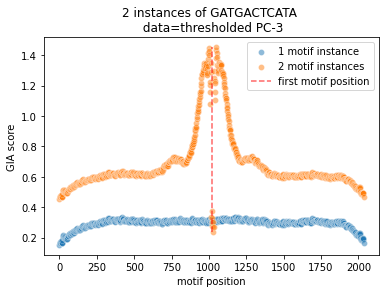

In [121]:
sns.scatterplot(x=all_positions, 
                y=all_position_scores, alpha=0.5, label='1 motif instance')

sns.scatterplot(x=range(0,len(all_position_scores_two)*2,2), 
                y=all_position_scores_two, alpha=0.5, label='2 motif instances')
plt.vlines(1024, np.min(all_position_scores_two), np.max(all_position_scores_two), 'r', 
           linestyle='--', alpha=0.6, label='first motif position')
plt.xlabel('motif position')
plt.ylabel('GIA score')

plt.legend()
plt.title('2 instances of {} \n data=thresholded {}'.format(best_motif_and_flanking_nucls, targets[cell_line]))

# do flanks matter?

In [353]:
gi = GlobalImportance(model, alphabet)
gi.set_null_model('none', base_sequence=low_X, quant=True, num_sample=1000, seed=42)  

seed set!


In [368]:
diff = gi.embed_predict_quant_effect([('TGA', 1024), 
                                      ('TCA', 1027)])
diff = gi.embed_predict_quant_effect([(best_motif_and_flanking_nucls, 1022)])

In [ ]:
metrics.get_correlation_per_seq()

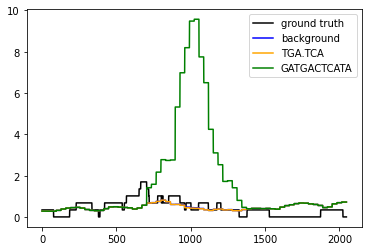

In [390]:
i = np.random.choice(1000)
plt.plot(low_Y[gi.null_sample_idx[i]], label='ground truth', c='k')
plt.plot(np.repeat(gi.null_profiles[:,:,cell_line][i], bin_size), 
         label='background', c='b')

plt.plot(np.repeat(gi.embedded_predictions['TGA at 1024 & TCA at 1027'][i,:,cell_line], bin_size),
        label='TGA.TCA', c='orange')
plt.plot(np.repeat(gi.embedded_predictions['GATGACTCATA at 1022'][i,:,cell_line], bin_size),
        label=best_motif_and_flanking_nucls, c='g')
plt.legend()

In [381]:
flank_dfs = [pd.DataFrame({'mean coverage':gi.null_profiles[:,:,cell_line].mean(axis=1),
                'motif':'background'})]
cell_line = 13

label_dict = {'TGA at 1024 & TCA at 1027':'TGA.TCA', 'GATGACTCATA at 1022':best_motif_and_flanking_nucls}

for l in gi.embedded_predictions.keys():
    flank_dfs.append(pd.DataFrame({'mean coverage':gi.embedded_predictions[l][:,:,cell_line].mean(axis=1),
    'motif':label_dict[l]}))
    print(l)
flank_dfs = pd.concat(flank_dfs)

TGA at 1024 & TCA at 1027
GATGACTCATA at 1022


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

background vs. TGA.TCA: Custom statistical test, P_val:7.790e-01
background vs. GATGACTCATA: Custom statistical test, P_val:5.623e-79


Text(0.5, 1.0, 'PC-3, low background')

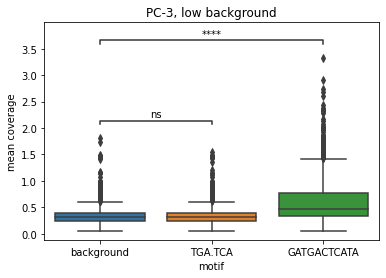

In [382]:
global_importance.boxplot_with_test(data=flank_dfs, 
                                    x='motif', 
                                    y='mean coverage', 
                                    pairs=[('GATGACTCATA', 'background'),('TGA.TCA', 'background')])
plt.title('PC-3, low background')

# do ATAAA and TGA.TCA interact?


First, choose flanking nucleotides for ATAAA

In [397]:
%%time
kmer_size = 6
kmers = ["".join(p) for p in itertools.product(list(alphabet), repeat=kmer_size)]
all_motifs = []
all_scores = []
motif_pattern = 'ATAAA'
for kmer in tqdm(kmers):
    all_scores_per_motif = []
    motif_with_flanking_nucls = kmer[:3]+motif_pattern+kmer[3:]
    all_motifs.append(motif_with_flanking_nucls)
    diff_scores = gi.embed_predict_quant_effect([(motif_with_flanking_nucls, 1024)])
    all_scores_per_motif=(diff_scores).mean(axis=0).mean(axis=0)
    all_scores.append(all_scores_per_motif)

100%|██████████| 4096/4096 [3:04:43<00:00,  2.71s/it]t]

CPU times: user 1h 18min 6s, sys: 11min 28s, total: 1h 29min 34s
Wall time: 3h 4min 43s


In [405]:
best_ataaa = all_motifs[np.array(all_scores)[:,13].argmax()]

/home/shush/tf_2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


([<matplotlib.axis.XTick at 0x7f4e5419e940>], [Text(0, 0, 'CTCATAAAACT')])

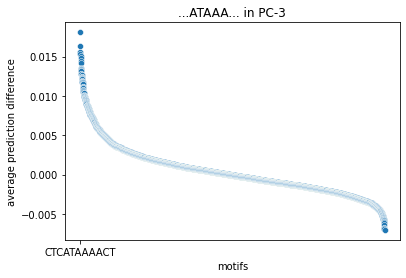

In [406]:
sns.scatterplot(range(len(all_motifs)), np.sort(np.array(all_scores)[:,13])[::-1])
plt.title('...ATAAA... in PC-3')
plt.xlabel('motifs')
plt.ylabel('average prediction difference')
plt.xticks([0], [best_ataaa])

In [166]:
cell_line

13

In [168]:
ataaa_tgatca_pos_scores = []
for position in tqdm(range(0,3,2)):
        diff_scores = gi.embed_predict_quant_effect([('ATA', 1024),
                                                     ('TTTA', 
                                                      position)])
        ataaa_tgatca_pos_scores.append((diff_scores[:,:,cell_line]).mean())
        break

  0%|          | 0/2 [00:00<?, ?it/s]


In [173]:
diff_scores.mean(axis=0).mean(axis=0)

(15,)

In [431]:
ataaa_tgatca_pos_scores = []
for position in tqdm(range(0,2048-len(best_ataaa),2)):
        diff_scores = gi.embed_predict_quant_effect([(best_motif_and_flanking_nucls, 1024),
                                                     (best_ataaa, 
                                                      position)])
        ataaa_tgatca_pos_scores.append((diff_scores[:,:,cell_line]).mean())

100%|██████████| 1019/1019 [45:24<00:00,  2.67s/it]


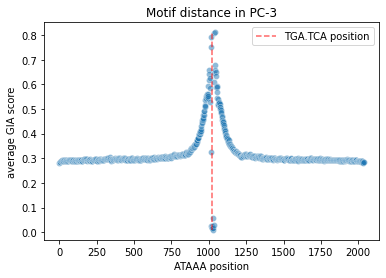

In [453]:
sns.scatterplot(x=range(0,len(ataaa_tgatca_pos_scores)*2,2), 
                y=ataaa_tgatca_pos_scores, alpha=0.5)
plt.vlines(1024, np.min(ataaa_tgatca_pos_scores), np.max(ataaa_tgatca_pos_scores), 'r', 
           linestyle='--', alpha=0.6, label='TGA.TCA position')
plt.ylabel('average GIA score')
plt.xlabel('ATAAA position')
plt.title('Motif distance in PC-3')
plt.legend()

In [435]:
best_ataaa_pos = list(range(0,2048-len(best_ataaa),2))[np.argmax(ataaa_tgatca_pos_scores)]
best_ataaa_pos

1040

Put ATAAA, TGA.TCA individually or in combination

In [436]:
gi = GlobalImportance(model, alphabet)
gi.set_null_model('none', base_sequence=low_X, quant=True, num_sample=1000, seed=42) 

seed set!


In [437]:
diff = gi.embed_predict_quant_effect([(best_ataaa, best_ataaa_pos)])
diff = gi.embed_predict_quant_effect([(best_motif_and_flanking_nucls, 1024)])
diff = gi.embed_predict_quant_effect([(best_ataaa, best_ataaa_pos), (best_motif_and_flanking_nucls, 1024)])

In [438]:
gi.embedded_predictions.keys()

dict_keys(['CTCATAAAACT at 1040', 'GATGACTCATA at 1024', 'CTCATAAAACT at 1040 & GATGACTCATA at 1024'])

In [439]:
cell_line = 13
flank_dfs = [pd.DataFrame({'mean coverage':gi.null_profiles[:,:,cell_line].mean(axis=1),
                'motif':'background'})]


label_dict = {'CTCATAAAACT at 1040': best_ataaa, 
              'GATGACTCATA at 1024':best_motif_and_flanking_nucls,
             'CTCATAAAACT at 1040 & GATGACTCATA at 1024': 'ATAAA and TGA.TCA'}

for l in gi.embedded_predictions.keys():
    flank_dfs.append(pd.DataFrame({'mean coverage':gi.embedded_predictions[l][:,:,cell_line].mean(axis=1),
    'motif':label_dict[l]}))
    print(l)
flank_dfs = pd.concat(flank_dfs)

CTCATAAAACT at 1040
GATGACTCATA at 1024
CTCATAAAACT at 1040 & GATGACTCATA at 1024


In [441]:
background_mean = np.mean(flank_dfs[flank_dfs['motif']=='background']['mean coverage'])
ataaa_mean = np.mean(flank_dfs[flank_dfs['motif']==best_ataaa]['mean coverage'])
tgatca_mean = np.mean(flank_dfs[flank_dfs['motif']==best_motif_and_flanking_nucls]['mean coverage'])
both_mean = np.mean(flank_dfs[flank_dfs['motif']=='ATAAA and TGA.TCA']['mean coverage'])
both_mean-background_mean > ataaa_mean-background_mean + tgatca_mean-background_mean

True

In [455]:
ataaa_gia_scores = flank_dfs[flank_dfs['motif']==best_ataaa]['mean coverage'] - flank_dfs[flank_dfs['motif']=='background']['mean coverage']
tgatca_gia_scores = flank_dfs[flank_dfs['motif']==best_motif_and_flanking_nucls]['mean coverage'] - flank_dfs[flank_dfs['motif']=='background']['mean coverage']
both_gia_scores = flank_dfs[flank_dfs['motif']=='ATAAA and TGA.TCA']['mean coverage'] - flank_dfs[flank_dfs['motif']=='background']['mean coverage']


In [458]:
((ataaa_gia_scores + tgatca_gia_scores) < both_gia_scores).sum()

985

In [472]:
interaction_df = pd.DataFrame({'GIA(TGATCA) + \nGIA(ATAAA)':(ataaa_gia_scores + tgatca_gia_scores), 
                              'GIA(TGATCA \nand ATAAA)':both_gia_scores})
interaction_df = interaction_df.melt(var_name='GIA experiment', value_name='score')


Text(0.5, 1.0, 'PC-3')

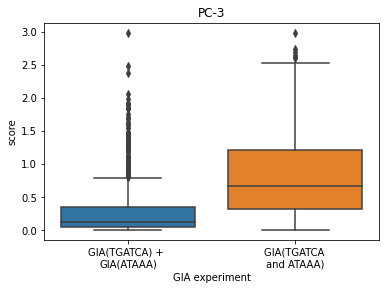

In [474]:
sns.boxplot(data=interaction_df, x='GIA experiment', y='score')
plt.title(targets[cell_line])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

background vs. CTCATAAAACT: Custom statistical test, P_val:3.364e-02
GATGACTCATA vs. ATAAA and TGA.TCA: Custom statistical test, P_val:1.436e-97
background vs. GATGACTCATA: Custom statistical test, P_val:1.140e-77
background vs. ATAAA and TGA.TCA: Custom statistical test, P_val:3.084e-237


(array([0, 1, 2, 3]),
 [Text(0, 0, 'background'),
  Text(1, 0, 'CTCATAAAACT'),
  Text(2, 0, 'GATGACTCATA'),
  Text(3, 0, 'ATAAA and TGA.TCA')])

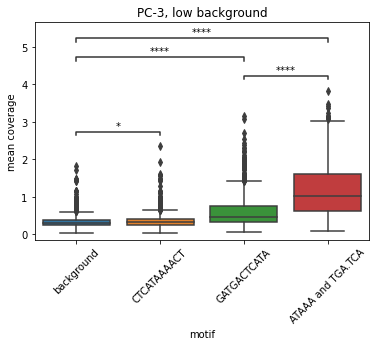

In [447]:
global_importance.boxplot_with_test(data=flank_dfs, 
                                    x='motif', 
                                    y='mean coverage', 
                                    pairs=[(best_ataaa, 'background'),
                                           (best_motif_and_flanking_nucls, 'background'),
                                           (best_motif_and_flanking_nucls, 'ATAAA and TGA.TCA'),
                                           ('background', 'ATAAA and TGA.TCA')])
plt.title('PC-3, low background')
plt.xticks(rotation=45)